# NAND Performances Analysis: block and page sizes

This simulation tries to understand the different performances of a NAND disk changing the number of blocks and the number of pages per block. The write\read parameters, as long the garbage collector, are kept unchanged.

This simulation collects 100 K samples based on host write requests. The simulation runs a random writes of pages, 4 KiB each. So, the total amount of data to be written is 390.625 [MiB].

There are various NAND cells simulated. All NANDs have the following common features:

* page size:               4096 [Bytes] (4 [KiB]);
* capacity:                128 [MiB];
* page write time:         40 [µs];
* page read time:          20 [µs];
* block erase time:        1500 [µs];
* max bandwidth read:      195.31 [MiB\s] (theoretical);
* max bandwidth write:     97.66 [MiB\s] (theoretical).

The garbage collector cleans a block when at least 40% of its pages are dirty and only if at least 0.5 seconds are elapsed after the last gc execution. If a block is full during a write, the block is modified in-memory and erased;

Then, every NAND has a different number of total blocks and pages per block (keeping the cell capacity constant):

* **2x16384** blocks: 2, pages per block: 16384;
* **16x2048** blocks: 16, pages per block: 2048;
* **32x1024** blocks: 32, pages per block: 1024;
* **64x512** blocks: 64, pages per block: 512;
* **128x256** blocks: 128, pages per block: 256;
* **256x128** blocks: 256, pages per block: 128;
* **512x64** blocks: 512, pages per block: 64;
* **1024x32** blocks: 1024, pages per block: 32.

**Note**: "2048x16", "4096x8", "16384x2" was not computed as the simulation is too expensive. In the following analysis is also clear that those combinations are useless.

In [1]:
# initialize
%matplotlib inline
import matplotlib.pyplot as plt
from simulator import analysis_helper as ah

# read the simulation data
sim_names = ("2x16384", "16x2048", "32x1024", "64x512", "128x256", "256x128", "512x64", "1024x32")
data = ah.load_data(sim_names, "../RESULTS/nand_parameters_test/")

## Page written host vs disk
This plot is in logaritmic scale and compares the host write requests (_x axis_) versus the effective disk writes (_y axis_). Ideally it should be linear: every host request correspond to a single disk write. Yet, due to the garbage collection or disk errors (_ie: disk is full_) the behaviour may change. 

The best result is **1024x32**. The best results are those with higher number of total blocks.

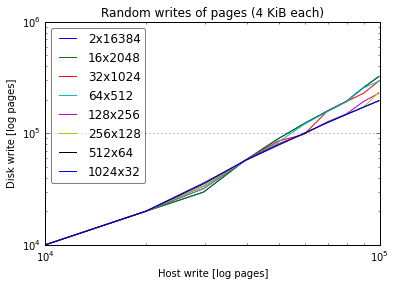

In [2]:
ah.inline_plot(sim_names, data, yid=6, xlog=True, ylog=True, show=False,
                xlabel="Host write [log pages]",
                ylabel="Disk write [log pages]")
# need extra parameters to better plotting
plt.axis([10 ** 4, 10 ** 5, 10 ** 4, 10 ** 6])  # [xmin, xmax, ymin, ymax]
plt.show()

## Host write time

This plot shows how much time is elapsed respect to the host write requests.

The best result is **128x256** (128 blocks of 256 pages each): it needs roughly 13 seconds to write the requested pages. 

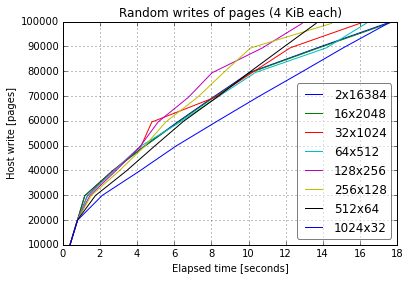

In [3]:
ah.plot_disk_write_time(sim_names, data)

## IOPS over written pages

This plot shows the IOPS as seen by the host over the write requests.

The best result is **2x16384**, yet all combinations with a small number of blocks have similar final IOPS values.

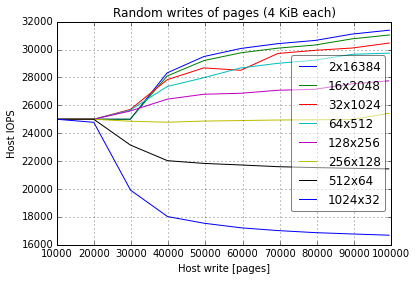

In [4]:
ah.plot_iops(sim_names, data)

## Amplification factor over written pages

This plot shows the amplification factor as seen by the host over the write requests. The amplification factor is defined as:
$$ A_f = \frac{W_s}{W_h} $$

Where:

* $W_s$ is the number of pages written actually by the disk;
* $W_h$ is the number of pages the host requests to write.


The results are heterogeneous. The disks with an high number of blocks (256, 512, 1024) have the same final amplification factor of 1.97, the best result. 

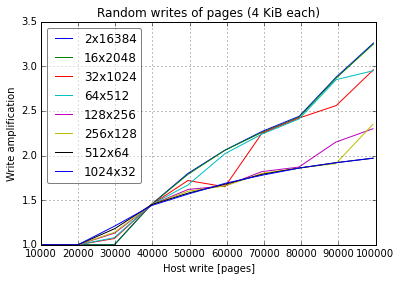

In [5]:
ah.plot_disk_af(sim_names, data)

## Write bandwidth over written pages

This plot shows the write bandwidth as seen by the host over the write requests.

Again, **128x256** is the best result with a final write bandwidth of 30.1 MiB/s.

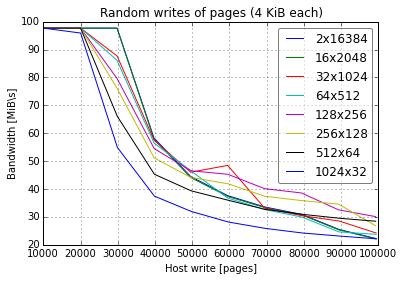

In [6]:
ah.plot_bandwidth(sim_names, data)

## Dirty pages over written pages

This plot shows the number of dirty pages over the write requests.

All disks starts the garbage collection after the first 20 K written pages. Some disks have a very low number of dirty pages, yet those disks doesn't have good performances.

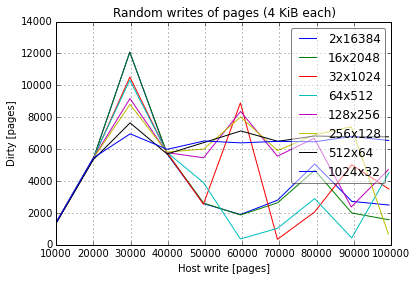

In [7]:
ah.plot_dirty_pages(sim_names, data)

## Write failures over written pages

This plot shows the number of failures (page not written due to disk errors) over the write requests.

All disks are able to fulfil the host requests.

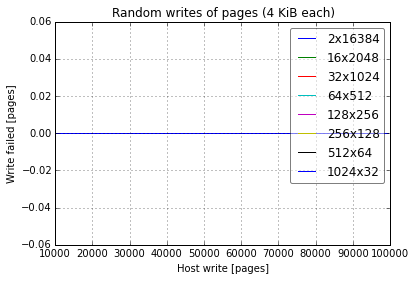

In [8]:
ah.plot_write_faiures(sim_names, data)

## Final Statistics

In [9]:
ah.generate_final_stats(sim_names, data)



2x16384        Min            Max            Mean           
time           0.40004        17.48272       6.49 ± 5.82
iops           25000          31385          28,645.20 ± 2,655.47
bandwidth      22.22          97.66          54.55 ± 31.39
amplification  1.0            3.26           1.92 ± 0.81
host write     10001          99469          54,656.10 ± 30,084.35
host read      0              0              0.00 ± 0.00
disk write     10001          324085         126,285.30 ± 106,612.57
disk read      0              224616         71,629.20 ± 77,669.59
block erased   0              18             6.20 ± 6.29
failures       0              0              0.00 ± 0.00
dirty pages    1379           12087          4,217.80 ± 3,156.94


16x2048        Min            Max            Mean           
time           0.40004        17.60408       6.54 ± 5.86
iops           25000          31041          28,429.90 ± 2,503.94
bandwidth      22.07          97.66          54.36 ± 31.49
amplification 

## Conclusions

The disk **128x256** (128 blocks with 256 pages each) is the most equilibrate solution. It has the best bandwidth, a good IOPS and a low amplification factor.

Is interesting that the best solution has large block compared to real products. Real products have many blocks with less pages.

Interesting, the best amplification factor is for **512x64** and **1024x32**, yet the overall performances of those solutions aren't good: erasing block is costly.